# detection d'artefact

In [1]:
import os

os.environ['USE_TORCH'] = '1'

import argparse
import logging
import numpy as np

import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import torch

from doctr.io.image import read_img_as_tensor
from doctr.models import obj_detection

In [14]:
CLASSES = ["__background__", "QR Code", "Barcode", "Logo", "Photo"]
# Color map for each class
CM = [(255, 255, 255), (0, 0, 150), (0, 0, 0), (0, 150, 0), (150, 0, 0)]

In [15]:
def plot_predictions(image, boxes, labels):
    for box, label in zip(boxes, labels):
        # Bounding box around artefacts
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]),
                      CM[label], 2)
        text_size, _ = cv2.getTextSize(CLASSES[label], cv2.FONT_HERSHEY_SIMPLEX, 2, 2)
        text_w, text_h = text_size
        # Filled rectangle above bounding box
        cv2.rectangle(image, (box[0], box[1]), (box[0] + text_w, box[1] - text_h),
                      CM[label], -1)
        # Text bearing the name of the artefact detected
        cv2.putText(image, CLASSES[label], (int(box[0]), int(box[1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)
    figure(figsize=(10, 8), dpi=90)
    plt.axis('off')
    plt.imshow(image)
    plt.show()

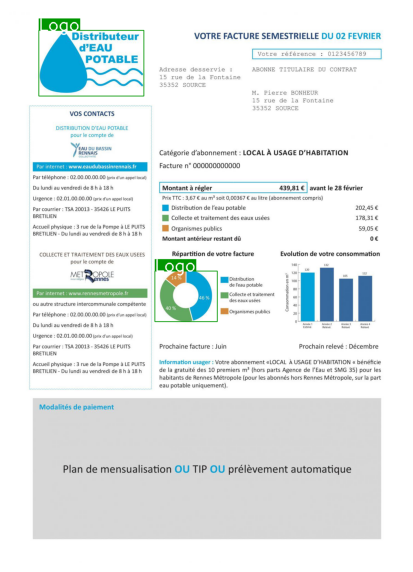

In [21]:
model = obj_detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True, num_classes=5).eval()

img_path = "img07.jpg"
# Reading the input image
img = read_img_as_tensor(img_path).unsqueeze(0)

if torch.cuda.is_available():
    model = model.cuda()
    img = img.cuda()

with torch.no_grad():
    pred = model(img)

labels = pred[0]['labels'].detach().cpu().numpy()
labels = labels.round().astype(int)
boxes = pred[0]['boxes'].detach().cpu().numpy()
boxes = boxes.round().astype(int)
img = (255 * img.cpu().squeeze(0).permute(1, 2, 0).numpy().copy()).round().astype(np.uint8)
plot_predictions(img, boxes, labels)